In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import xpress  as xp

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/andrea/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [2]:
# input
L = 2

custom_setup = True
if custom_setup:
    C = 8
else:
    C = 10 # change this input for other runs

map_size = 100
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [3]:
# define the locations of customers and lockers and warehouse
if custom_setup:
    C_location = 100*np.array([[0.1 ,0.28], [0.2 ,0.4],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],[0.7 ,0.4],[0.9 ,0.5], [0.4, 0.15]])
    W_location = 100*np.array([[0.6 ,0.5]])
    L_location = 100*np.array([[0.3 ,0.5],[0.5,0.2]])
else:
    C_location = np.random.randint(map_size, size=(C, 2))
    W_location = np.random.randint(map_size, size=(1, 2))
    L_location = np.random.randint(map_size, size=(L, 2))
stores_location = np.concatenate((W_location, L_location), axis=0)

In [4]:
def euclidean_distance(location_a, location_b):
    if len(location_a) != 2 or len(location_b) != 2:
        raise Exception("the two location need to be a list each of size 2")
    delta_x = location_b[0]-location_a[0]
    delta_y = location_b[1]-location_a[1]
    return math.sqrt(delta_x*delta_x+delta_y*delta_y)

def find_nearest_stores_from_customer(customer_location, stores_location_par):
    min_distance = float("inf")
    nearest_store_location = []
    index = 0
    nearest_locker_index = -1
    for store_location in stores_location_par:
        distance = euclidean_distance(customer_location, store_location)
        if distance < min_distance:
            min_distance = distance
            nearest_store_location = store_location
            nearest_locker_index = index
        index +=1
    return nearest_locker_index, nearest_store_location


In [5]:
# Customers’ demand and preferences

# define all the stores: eg. stores = [W, L0, L1, .... , Lx]
warehouse = ["W"]
lockers = []
for l in range(L):
    lockers.append("L"+str(l))
stores = warehouse+lockers

if custom_setup:
    C_L = [0, 5, 7]
    C_D = [1, 2, 3, 4, 6]
    S_k =[1, 2, 6]
    a_k = ["L0", "W", "L1"]
else:
    C_L = []
    C_D = []
    S_k = []
    a_k = []
    for client in range(C):
        if random.random()  <= ratio_locker_customers :
            # locker customer
            C_L.append(client)
            a_k.append(random.choice(stores))
        else:
            # door to door customer
            C_D.append(client)
            if random.random() >= ratio_prime_door_to_door_customer:
                S_k.append(client)

In [6]:
# Capacities

q_c = np.ones(C)
q_CD = np.ones(len(C_D)) # TODO take the value of q_c only in the index of a CD customer
q_CL = np.ones(len(C_L)) # TODO take the value of q_c only in the index of a CL customer
q_SK = np.ones(len(S_k)) # TODO take the value of q_c only in the index of a S_k customer

# PF vehicles capacities
Q = math.ceil(0.5 * len(C_D))
# locker storage (every locker has the same capacity by default)
W_l = []
for i in range(L):
    W_l.append(math.ceil(0.8 * C / L))
# LF vehicles capacities (every LF vehicle has the same capacity by default)
Q_l = []
for i in range(L):
    Q_l.append(math.ceil(0.6 * W_l[i]))

sum_W_l = 0
for i in range(len(W_l)):
    sum_W_l += W_l[i]


# supply vehicles storage
Q_L = math.ceil(0.8 * sum_W_l)

print("Q: ",Q)
print("W_l: ",W_l)
print("Q_l: ",Q_l)
print("Q_L: ",Q_L)
print("sum_W_l: ", sum_W_l)


Q:  3
W_l:  [4, 4]
Q_l:  [3, 3]
Q_L:  7
sum_W_l:  8


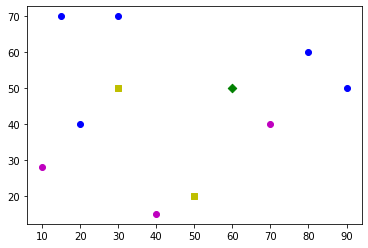

In [7]:
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
S_k_location = np.array([[0,0]])
for i in range(C):
    if i in  C_D:
        CD_location=np.vstack([CD_location, C_location[i]])
    else:
        CL_location = np.vstack([CL_location, C_location[i]])
for i in range(C):
    if i in S_k:
        S_k_location=np.vstack([S_k_location,C_location[i]])

S_k_location=np.delete(S_k_location,0,0)
CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)

#define indexes for the subset S_k
S_k_indexes = []
for s in range(len(S_k_location)):
    S_k_indexes.append("Sk"+str(s))


#define all customers
Customers = []
Customers_door = []
Customers_locker = []
for c in range(len(C_D)):
    Customers_door.append("Cd"+str(c))
for c in range(len(C_L)):
    Customers_locker.append("Cl"+str(c))

Customers = Customers_door+Customers_locker


plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

#piccola nota
#come nel paper in verde è la warehouse, in giallo i locker, mentre in blu in customer door to door e in magenta i customer locker

In [8]:
#calcolo la matrice delle distanze:
all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + Customers

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)

for i in range(len(dist_matrix)):
    dist_matrix.values[i][i]=100000
print(dist_matrix)


             W         L0         L1        Cd0        Cd1        Cd2  \
W     0.000000  30.000000  31.622777  41.231056  49.244289  36.055513   
L0   30.000000   0.000000  36.055513  14.142136  25.000000  20.000000   
L1   31.622777  36.055513   0.000000  36.055513  61.032778  53.851648   
Cd0  41.231056  14.142136  36.055513   0.000000  30.413813  31.622777   
Cd1  49.244289  25.000000  61.032778  30.413813   0.000000  15.000000   
Cd2  36.055513  20.000000  53.851648  31.622777  15.000000   0.000000   
Cd3  22.360680  50.990195  50.000000  63.245553  65.764732  50.990195   
Cd4  30.000000  60.000000  50.000000  70.710678  77.620873  63.245553   
Cl0  54.626001  29.732137  40.792156  15.620499  42.296572  46.518813   
Cl1  14.142136  41.231056  28.284271  50.000000  62.649820  50.000000   
Cl2  40.311289  36.400549  11.180340  32.015621  60.415230  55.901699   

           Cd3        Cd4        Cl0        Cl1        Cl2  
W    22.360680  30.000000  54.626001  14.142136  40.311289  
L

In [9]:
#filter data
supply_distances_matrix = dist_matrix.filter(items=stores, axis=1)
supply_distances_matrix = supply_distances_matrix.filter(items=stores, axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=['W'] + Customers_door, axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=['W'] + Customers_door, axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+Customers_door, axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers + Customers_door, axis=0)
print(LF_distances_matrix)

                W             L0             L1
W   100000.000000      30.000000      31.622777
L0      30.000000  100000.000000      36.055513
L1      31.622777      36.055513  100000.000000
                 W            Cd0            Cd1            Cd2  \
W    100000.000000      41.231056      49.244289      36.055513   
Cd0      41.231056  100000.000000      30.413813      31.622777   
Cd1      49.244289      30.413813  100000.000000      15.000000   
Cd2      36.055513      31.622777      15.000000  100000.000000   
Cd3      22.360680      63.245553      65.764732      50.990195   
Cd4      30.000000      70.710678      77.620873      63.245553   

               Cd3            Cd4  
W        22.360680      30.000000  
Cd0      63.245553      70.710678  
Cd1      65.764732      77.620873  
Cd2      50.990195      63.245553  
Cd3  100000.000000      14.142136  
Cd4      14.142136  100000.000000  
                L0             L1            Cd0            Cd1  \
L0   100000.000000 

In [10]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)

               W            L0            L1
W   75000.000000     22.500000     23.717082
L0     22.500000  75000.000000     27.041635
L1     23.717082     27.041635  75000.000000
                 W            Cd0            Cd1            Cd2  \
W    100000.000000      41.231056      49.244289      36.055513   
Cd0      41.231056  100000.000000      30.413813      31.622777   
Cd1      49.244289      30.413813  100000.000000      15.000000   
Cd2      36.055513      31.622777      15.000000  100000.000000   
Cd3      22.360680      63.245553      65.764732      50.990195   
Cd4      30.000000      70.710678      77.620873      63.245553   

               Cd3            Cd4  
W        22.360680      30.000000  
Cd0      63.245553      70.710678  
Cd1      65.764732      77.620873  
Cd2      50.990195      63.245553  
Cd3  100000.000000      14.142136  
Cd4      14.142136  100000.000000  
               L0            L1           Cd0           Cd1           Cd2  \
L0   85000.000000    

In [11]:
LF_delivery_cost_multidim = np.zeros((L,len(C_D)+1,len(C_D)+1))

for i in range(L):
    l = [0]
    l[0]=lockers[i]
    ls = LF_delivery_cost.filter(items=l+Customers_door,axis=1)
    ls = ls.filter(items=l+Customers_door,axis=0)
    print(ls)
    lt = ls.to_numpy()
    for j in range(1+len(C_D)):
        for k in range(1+len(C_D)):
            LF_delivery_cost_multidim[i][j][k]=lt[j][k]



               L0           Cd0           Cd1           Cd2           Cd3  \
L0   85000.000000     12.020815     21.250000     17.000000     43.341666   
Cd0     12.020815  85000.000000     25.851741     26.879360     53.758720   
Cd1     21.250000     25.851741  85000.000000     12.750000     55.900022   
Cd2     17.000000     26.879360     12.750000  85000.000000     43.341666   
Cd3     43.341666     53.758720     55.900022     43.341666  85000.000000   
Cd4     51.000000     60.104076     65.977742     53.758720     12.020815   

              Cd4  
L0      51.000000  
Cd0     60.104076  
Cd1     65.977742  
Cd2     53.758720  
Cd3     12.020815  
Cd4  85000.000000  
               L1           Cd0           Cd1           Cd2           Cd3  \
L1   85000.000000     30.647186     51.877861     45.773901     42.500000   
Cd0     30.647186  85000.000000     25.851741     26.879360     53.758720   
Cd1     51.877861     25.851741  85000.000000     12.750000     55.900022   
Cd2     45.7

In [12]:
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,S_k_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+S_k_indexes)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)

print(compensation_matrix)


distance_matrix_customer_locker_store = dist_matrix.filter(items=Customers_locker,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)
print(distance_matrix_customer_locker_store)


closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
print(closest_store_to_CL)

index_close_locker = []
for i in range(len(closest_store_to_CL)):
    index_close_locker.append(closest_store_to_CL[i])
print(index_close_locker)


# TODO matrix layout to reformat
d_ak_c = compensation_matrix.filter(items = S_k_indexes,axis=1)
d_ak_c=d_ak_c.filter(items=index_close_locker,axis=0)
print(d_ak_c)

ro = 0.5
compensation_matrix_cost = ro*d_ak_c
print(compensation_matrix_cost)
compensation_matrix_cost_multidim = compensation_matrix_cost.to_numpy()
print(compensation_matrix_cost_multidim)


             W         L0         L1        Sk0        Sk1        Sk2
W     0.000000  30.000000  31.622777  41.231056  49.244289  30.000000
L0   30.000000   0.000000  36.055513  14.142136  25.000000  60.000000
L1   31.622777  36.055513   0.000000  36.055513  61.032778  50.000000
Sk0  41.231056  14.142136  36.055513   0.000000  30.413813  70.710678
Sk1  49.244289  25.000000  61.032778  30.413813   0.000000  77.620873
Sk2  30.000000  60.000000  50.000000  70.710678  77.620873   0.000000
          Cl0        Cl1        Cl2
W   54.626001  14.142136  40.311289
L0  29.732137  41.231056  36.400549
L1  40.792156  28.284271  11.180340
Cl0    L0
Cl1     W
Cl2    L1
dtype: object
['L0', 'W', 'L1']
          Sk0        Sk1   Sk2
L0  14.142136  25.000000  60.0
W   41.231056  49.244289  30.0
L1  36.055513  61.032778  50.0
          Sk0        Sk1   Sk2
L0   7.071068  12.500000  30.0
W   20.615528  24.622145  15.0
L1  18.027756  30.516389  25.0
[[ 7.07106781 12.5        30.        ]
 [20.61552813 24.

In [24]:
# Xpress formulation
single_period_problem = xp.problem()

In [25]:
# var definition
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)
x_i_j = np.array([[xp.var(name="x_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_PF)]for j in range(J_PF)], dtype=xp.npvar)
y_i_j = np.array([[xp.var(name="y_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for i in range(I_PF)]for j in range(J_PF)], dtype=xp.npvar)

I_L = 1 + L
J_L = 1 + L
x_i_j_L = np.array([[xp.var(name="x_L_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_L)]for j in range(J_L)], dtype=xp.npvar)
y_i_j_L = np.array([[xp.var(name="y_L_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for i in range(I_L)]for j in range(J_L)], dtype=xp.npvar)

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)
x_l_i_j = np.array([[[xp.var(name="x_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_LF)]for j in range(J_LF)] for l in range(L)], dtype=xp.npvar)
y_l_i_j = np.array([[[xp.var(name="y_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.integer, lb=0) for i in range(I_LF)]for j in range(J_LF)] for l in range(L)], dtype=xp.npvar)

z_c = np.array([xp.var(name="z_c"+str(c), vartype=xp.binary) for c in range(len(C_D))], dtype=xp.npvar)
z_c_l = np.array([[xp.var(name="z_c"+str(c)+"_l"+str(l), vartype=xp.binary) for c in range(len(C_D))]for l in range(L)], dtype=xp.npvar)
z_l_L = np.array([[xp.var(name="z_l_L_"+str(l), vartype=xp.binary) for l in range(L)]], dtype=xp.npvar)

w_c_k = np.array([[xp.var(name="w_c"+str(c)+"_k"+str(k), vartype=xp.binary) for c in range(len(S_k))]for k in range(len(C_L))], dtype=xp.npvar)

# add var to the problem
single_period_problem.addVariable(x_i_j)
single_period_problem.addVariable(x_i_j_L)
single_period_problem.addVariable(x_l_i_j)

single_period_problem.addVariable(y_i_j)
single_period_problem.addVariable(y_i_j_L)
single_period_problem.addVariable(y_l_i_j)

single_period_problem.addVariable(z_c)
single_period_problem.addVariable(z_c_l)
single_period_problem.addVariable(z_l_L)

single_period_problem.addVariable(w_c_k)


In [26]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstraint( z_c[c] + xp.Sum(w_c_k[s][k] for s in range(len(S_k)) for k in range(len(C_L))) + xp.Sum(z_c_l[l][c] for l in range(L)) == 1)

# constraint eq. 3
for c_l in range(len(C_L)):
    single_period_problem.addConstraint( xp.Sum(w_c_k[c_l][s_k] for s_k in range(len(S_k))) <= 1)


# constraint eq. 4
for l in range(L):
    single_period_problem.addConstraint(
        xp.Sum(q_CL[cl] + xp.Sum(q_SK[sk]*w_c_k[cl][sk] for sk in range(len(S_k))) for cl in range(len(C_L)))
        + xp.Sum(q_CD[cd]*z_c_l[l][cd] for cd in range(len(C_D)))
        <= W_l[l] * z_l_L[0][l]
    )

# Professional fleet constraint

# constraint eq. 5.1 A == C
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[i+1][j] for j in range(len(C_D)+1))
        == z_c[i]
    )


# constraint eq. 5.2 B == C
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[j][i+1] for j in range(len(C_D)+1))
        == z_c[i]
    )

# constraint eq. 5.3 A == B
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[i+1][j] for j in range(len(C_D)+1))
        ==
        xp.Sum( x_i_j[j][i+1] for j in range(len(C_D)+1))
    )


# constraint eq. 6
single_period_problem.addConstraint(
    xp.Sum( x_i_j[0][j+1] for j in range(len(C_D)))
    - xp.Sum( x_i_j[j+1][0] for j in range(len(C_D)))
    == 0
)

# constraint eq. 7
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( y_i_j[j][i+1] for j in range(1+len(C_D)))
        - xp.Sum( y_i_j[i+1][j] for j in range(1+len(C_D)))
        == q_CD[i]*z_c[i]
    )

# constraint eq. 8
single_period_problem.addConstraint(
    xp.Sum( y_i_j[j+1][0] for j in range(len(C_D)))
    - xp.Sum( y_i_j[0][j+1] for j in range(len(C_D)))
    == - xp.Sum( q_CD[i]*z_c[i] for i in range(len(C_D)))
)

# constraint eq. 9
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        single_period_problem.addConstraint(
            y_i_j[i][j]
            <= Q * x_i_j[i][j]
        )

# constraint eq. 10
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        y_i_j[i+1][0]
        == 0
    )

# Supply routes constraints

# constraint eq. 11.1 A == C
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j_L[i+1][j] for j in range(1 + L))
        == z_l_L[0][i]
    )

# constraint eq. 11.2 B == C
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j_L[j][i+1] for j in range(1 + L))
        == z_l_L[0][i]
    )

# constraint eq. 11.3 A == B
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j_L[i+1][j] for j in range(1 + L))
        ==
        xp.Sum( x_i_j_L[j][i+1] for j in range(1 + L))
    )

# constraint eq. 12
single_period_problem.addConstraint(
    xp.Sum( x_i_j_L[0][j+1] for j in range(L))
    - xp.Sum( x_i_j_L[j+1][0] for j in range(L))
    == 0
)

# constraint eq. 13
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( y_i_j_L[j][i+1] for j in range(1+L))
        - xp.Sum( y_i_j_L[i+1][j] for j in range(1+L))
        ==
        xp.Sum(q_CL[cl] + xp.Sum(q_SK[sk]*w_c_k[cl][sk] for sk in range(len(S_k))) for cl in range(len(C_L)))
        + xp.Sum(q_CD[c]*z_c_l[i][c] for c in range(len(C_D)))
    )

# constraint eq. 14
single_period_problem.addConstraint(
    xp.Sum( y_i_j_L[j+1][0] for j in range(L))
    - xp.Sum( y_i_j_L[0][j+1] for j in range(L))
    == - xp.Sum(
    xp.Sum(q_CL[cl] + xp.Sum(q_SK[sk]*w_c_k[cl][sk] for sk in range(len(S_k))) for cl in range(len(C_L)))
    + xp.Sum(q_CD[c]*z_c_l[i][c] for c in range(len(C_D)))
    for i in range(L)
    )
)

# constraint eq. 15
for i in range(1 + L):
    for j in range(1 + L):
        single_period_problem.addConstraint(
            y_i_j_L[i][j]
            <= Q_L * x_i_j_L[i][j]
        )

# constraint eq. 16
for i in range(L):
    single_period_problem.addConstraint(
        y_i_j_L[i+1][0]
        == 0
    )

# Local fleet constraints
for l in range(L):
    # constraint eq. 17.1 A == C
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( x_l_i_j[l][i+1][j] for j in range(len(C_D)+1))
            == z_c_l[l][i]
        )


    # constraint eq. 17.2 B == C
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( x_l_i_j[l][j][i+1] for j in range(len(C_D)+1))
            == z_c_l[l][i]
        )

    # constraint eq. 17.3 A == B
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( x_l_i_j[l][i+1][j] for j in range(len(C_D)+1))
            ==
            xp.Sum( x_l_i_j[l][j][i+1] for j in range(len(C_D)+1))
        )

    # constraint eq. 18
    single_period_problem.addConstraint(
        xp.Sum( x_l_i_j[l][0][j+1] for j in range(len(C_D)))
        - xp.Sum( x_l_i_j[l][j+1][0] for j in range(len(C_D)))
        == 0
    )

    # constraint eq. 19
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( y_l_i_j[l][j][i+1] for j in range(1+len(C_D)))
            - xp.Sum( y_l_i_j[l][i+1][j] for j in range(1+len(C_D)))
            == q_CD[i]*z_c_l[l][i]
        )

    # constraint eq. 20
    single_period_problem.addConstraint(
        xp.Sum( y_l_i_j[l][j+1][0] for j in range(len(C_D)))
        - xp.Sum( y_l_i_j[l][0][j+1] for j in range(len(C_D)))
        == - xp.Sum( q_CD[i]*z_c_l[l][i] for i in range(len(C_D)))
    )

    # constraint eq. 21
    for i in range(1 + len(C_D)):
        for j in range(1 + len(C_D)):
            single_period_problem.addConstraint(
                y_l_i_j[l][i][j]
                <= Q_l[l] * x_l_i_j[l][i][j]
            )

    # constraint eq. 22
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            y_l_i_j[l][i+1][0]
            == 0
        )

print(len(single_period_problem.getConstraint()))


220


eq. 13 -> 82 constraints

In [27]:
print(compensation_matrix_cost)


          Sk0        Sk1   Sk2
L0   7.071068  12.500000  30.0
W   20.615528  24.622145  15.0
L1  18.027756  30.516389  25.0


In [28]:
single_period_problem.setObjective(
    xp.Sum( xp.Sum(supply_cost.values[i][j]*x_i_j_L[i][j]   for j in range(1+L) )  for i in range(1+L))+
    xp.Sum( xp.Sum(compensation_matrix_cost_multidim[k][c] *w_c_k[c][k]  for c in range(len(S_k)))for k in range(len(C_L)))+
    xp.Sum( xp.Sum(PF_delivery_cost.values[i][j]*x_i_j[i][j] for j in range(1+len(C_D) ) )for i in range(1+len(C_D))) +
    xp.Sum( xp.Sum(xp.Sum(LF_delivery_cost_multidim[l][i][j]*x_l_i_j[l][i][j] for j in range(1+len(C_D)))for i in range(1+len(C_D)))for l in range(L))
    ,sense=xp.minimize
    )   #sense=minimise is the default value

In [29]:
single_period_problem.solve()

x_i_j_sol = single_period_problem.getSolution(x_i_j)
print("\n\n Solution:\n",x_i_j_sol, "\n")
x_i_j_L_sol = single_period_problem.getSolution(x_i_j_L)
print("\n\n Solution:\n",x_i_j_L_sol, "\n")
x_l_i_j_sol = single_period_problem.getSolution(x_l_i_j)
print("\n\n Solution:\n",x_l_i_j_sol, "\n")
w_c_k_sol = single_period_problem.getSolution(w_c_k)
print("\n\n Solution:\n",w_c_k_sol, "\n")

FICO Xpress v8.13.5, Community, solve started 11:01:19, Jun 7, 2022
Heap usage: 439KB (peak 459KB, 530KB system)
Minimizing MILP noname using up to 4 threads, with these control settings:
OUTPUTLOG = 1
Original problem has:
       220 rows          260 cols         1037 elements       260 globals
Presolved problem has:
        40 rows           62 cols          261 elements        62 globals
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 524KB (peak 704KB, 530KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  7.00e+00] / [ 1.25e-01,  1.75e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  6.00e+00] / [ 1.00e+00,  7.00e+00]
  Objective      [min,max] : [ 7.07e+00,  1.00e+05] / [ 3.46e-01,  1.84e+02]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 5.8GB
 *** Solution found:    99.505233   Time:   0    Heuristic: e ***
Starting concurrent solve wi

In [30]:
print("Objective val: ",single_period_problem.getObjVal())
print(single_period_problem.getSolution(z_c))
print(single_period_problem.getSolution(z_c_l))
print(single_period_problem.getSolution(z_l_L))


Objective val:  99.50523271439113
[0. 0. 0. 0. 0.]
[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]]
[[1. 1.]]
